In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from os import listdir
from os.path import isfile, join
from collections import namedtuple
from tensorflow.python.layers.core import Dense
from tensorflow.python.ops.rnn_cell_impl import _zero_state_tensors
import time
import re
from sklearn.model_selection import train_test_split
from tensorflow import keras
import glob
import csv
import random
import pyarabic.araby as araby
import random
import string

In [ ]:
path='/content/Arabic_names.csv'

In [ ]:
def male_female_names(path):
    males = []
    females = []
    names = glob.glob(path)
    for csv_file_name in names:
        with open(csv_file_name,'r',encoding='utf-8') as f:
            csv_reader = csv.reader(f)
            next(csv_reader)
            for row in csv_reader:
                if row[1].lower() =='f':
                    females.append(row[0])
                elif row[1].lower() =='m':
                    males.append(row[0])
    return males,females

In [ ]:
males, females = male_female_names(path)

In [ ]:
males

['ابراهيم',
 'اسلم',
 'البراء',
 'الحبيب',
 'الخضر',
 'العابدين',
 'المثنى',
 'آدم',
 'أبان',
 'أبلج',
 'أبو بكر',
 'أجاويد',
 'أجيد',
 'أحمد',
 'أحنف',
 'أخزم',
 'أخضر',
 'أخطب',
 'أدعج',
 'أدغم',
 'أدهم',
 'أديب',
 'أرغد',
 'أرقم',
 'أريب',
 'أزهر',
 'أزور',
 'أسامة',
 'أسد',
 'أسعد',
 'أسلم',
 'أسمر',
 'أشجع',
 'أشرف',
 'أشرم',
 'أشقر',
 'أشهب',
 'أشهم',
 'أشيم',
 'أصيل',
 'أعسر',
 'أغلب',
 'أغيد',
 'أكبر',
 'أكثم',
 'أكرم',
 'أكمل',
 'أمان',
 'أمجد',
 'أمية',
 'أمير',
 'أمين',
 'أنس',
 'أنعم',
 'أنمار',
 'أنور',
 'أهيم',
 'أوس',
 'أويس',
 'أيسر',
 'أيمن',
 'أيهم',
 'أيوب',
 'إبراهيم',
 'إحسان',
 'إدريس',
 'إسحاق',
 'إسلام',
 'إسماعيل',
 'إمام',
 'إياد',
 'إياس',
 'إيهاب',
 'باتل',
 'بادي',
 'بارح',
 'بارع',
 'باسط',
 'باسق',
 'باسل',
 'باسم',
 'باشق',
 'باهر',
 'بدر',
 'بديع',
 'براء',
 'برد',
 'برهان',
 'بسام',
 'بسيم',
 'بشار',
 'بشارة',
 'بشر',
 'بشير',
 'بطاح',
 'بطرس',
 'بكار',
 'بكر',
 'بكري',
 'بلال',
 'بليغ',
 'بندر',
 'بهاء',
 'بهجت',
 'بهلول',
 'بهيج',
 'تائب',
 'تامر',
 

In [ ]:
def name_generator(gender):
    first_name = ''
    if gender.lower() == 'f':
        first_name = random.choice(females)
    else:
        first_name = random.choice(males)
    second_name = random.choice(males)
    third_name = random.choice(males)
    forth_name = random.choice(males)
    full_name = first_name +' ' +second_name +' ' +third_name +' ' +forth_name
    temp = full_name
    return araby.normalize_alef(full_name).replace('ؤ','و'),temp

In [ ]:
gen=['m','f']
noisy_data=[]
correct_data=[]
for n in gen:
  for i in range(5000):
    data1,data2=name_generator(n)
    noisy_data.append(data1)
    correct_data.append(data2)

In [ ]:
with open("/content/data.txt", "w") as f:
    for word in correct_data:
        f.write(word)
        f.write("\n")

In [ ]:
batch_size = 128  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 128  # Latent dimensionality of the encoding space.
output_dim = 64

In [ ]:
letter=['ء','آ','أ','ؤ','إ','ئ','ا','ب','ة','ت','ث','ج','ح','خ','د','ذ','ر','ز','س','ش','ص','ض','ط','ظ','ع','غ','ف','ق','ك','ل','م', 'ن','ه','و','ى','ي']

In [ ]:
# Vectorize the data.

input_texts = []
target_texts = []
input_ =[]
tar_ =[]
input_characters = set()
target_characters = set()
character=[]
with open('/content/data.txt', "r", encoding="utf-8") as f:
    lines = f.read().split("\n")

for line in lines[: min(10000, len(lines) - 1)]:
  for _ in range(10):
      input_text = line
      #input_text = input_text.lower()
      #input_text = re.sub(r'[^a-zA-Z ]+', '', input_text)
      target_text = "\t" + input_text + "\n"
      #target_characters = sorted(list(target_characters))
      for i in range(np.random.choice(np.arange(0, 2), p=[0.1, 0.9])):
          input_text = input_text.replace(random.choice(list(input_text)),random.choice(letter))

      input_texts.append(input_text)
      target_texts.append(target_text)
      for char in input_text:
          if char not in input_characters:
              input_characters.add(char)
      for char in target_text:
          if char not in target_characters:
              target_characters.add(char)


input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])
print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

Number of samples: 100000
Number of unique input tokens: 37
Number of unique output tokens: 39
Max sequence length for inputs: 35
Max sequence length for outputs: 37


In [ ]:
input_texts[:3]

['يكين نايي عبدالعزيز غفار',
 'مكين نامي عبدالعغيغ غفار',
 'مكضن نامض عبدالعزضز غفار']

In [ ]:
target_texts[:3]

['\tمكين نامي عبدالعزيز غفار\n',
 '\tمكين نامي عبدالعزيز غفار\n',
 '\tمكين نامي عبدالعزيز غفار\n']

In [ ]:
input_characters = set()
target_characters = set()
for input_text in noisy_data:
  for char in input_text:
    if char not in input_characters:
      input_characters.add(char)
for target_text in correct_data:
  target_text= "\t" + target_text + "\n"
  for char in target_text:
    if char not in target_characters:
      target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in noisy_data])
max_decoder_seq_length = max([len(txt) for txt in correct_data])

print("Number of samples:", len(noisy_data))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(noisy_data), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(noisy_data), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(noisy_data), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(noisy_data, correct_data)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

Number of samples: 200000
Number of unique input tokens: 32
Number of unique output tokens: 39
Max sequence length for inputs: 39
Max sequence length for outputs: 39


In [ ]:
input_characters

[' ',
 'ء',
 'آ',
 'أ',
 'ؤ',
 'إ',
 'ئ',
 'ا',
 'ب',
 'ة',
 'ت',
 'ث',
 'ج',
 'ح',
 'خ',
 'د',
 'ذ',
 'ر',
 'ز',
 'س',
 'ش',
 'ص',
 'ض',
 'ط',
 'ظ',
 'ع',
 'غ',
 'ف',
 'ق',
 'ك',
 'ل',
 'م',
 'ن',
 'ه',
 'و',
 'ى',
 'ي']

In [ ]:
target_characters

['\t',
 '\n',
 ' ',
 'ء',
 'آ',
 'أ',
 'ؤ',
 'إ',
 'ئ',
 'ا',
 'ب',
 'ة',
 'ت',
 'ث',
 'ج',
 'ح',
 'خ',
 'د',
 'ذ',
 'ر',
 'ز',
 'س',
 'ش',
 'ص',
 'ض',
 'ط',
 'ظ',
 'ع',
 'غ',
 'ف',
 'ق',
 'ك',
 'ل',
 'م',
 'ن',
 'ه',
 'و',
 'ى',
 'ي']

In [ ]:
target_text

'\tحنيفة هبيرة تمام نجاد\n'

In [ ]:
len(encoder_input_data[0])

35

In [ ]:
input_token_index

{' ': 0,
 'ء': 1,
 'آ': 2,
 'أ': 3,
 'ؤ': 4,
 'إ': 5,
 'ئ': 6,
 'ا': 7,
 'ب': 8,
 'ة': 9,
 'ت': 10,
 'ث': 11,
 'ج': 12,
 'ح': 13,
 'خ': 14,
 'د': 15,
 'ذ': 16,
 'ر': 17,
 'ز': 18,
 'س': 19,
 'ش': 20,
 'ص': 21,
 'ض': 22,
 'ط': 23,
 'ظ': 24,
 'ع': 25,
 'غ': 26,
 'ف': 27,
 'ق': 28,
 'ك': 29,
 'ل': 30,
 'م': 31,
 'ن': 32,
 'ه': 33,
 'و': 34,
 'ى': 35,
 'ي': 36}

In [ ]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=20,
    validation_split=0.2,
)
# Save model
model.save("s2s")

Epoch 1/20
625/625 [==============================] - 9s 12ms/step - loss: 1.6115 - accuracy: 0.5649 - val_loss: 1.3475 - val_accuracy: 0.6178
Epoch 2/20
625/625 [==============================] - 6s 10ms/step - loss: 1.2576 - accuracy: 0.6414 - val_loss: 1.2118 - val_accuracy: 0.6516
Epoch 3/20
625/625 [==============================] - 6s 10ms/step - loss: 1.1231 - accuracy: 0.6755 - val_loss: 1.0798 - val_accuracy: 0.6837
Epoch 4/20
625/625 [==============================] - 6s 10ms/step - loss: 0.9713 - accuracy: 0.7167 - val_loss: 0.9168 - val_accuracy: 0.7343
Epoch 5/20
625/625 [==============================] - 6s 10ms/step - loss: 0.8273 - accuracy: 0.7591 - val_loss: 0.7926 - val_accuracy: 0.7691
Epoch 6/20
625/625 [==============================] - 6s 10ms/step - loss: 0.7175 - accuracy: 0.7912 - val_loss: 0.7016 - val_accuracy: 0.7950
Epoch 7/20
625/625 [==============================] - 6s 10ms/step - loss: 0.6299 - accuracy: 0.8170 - val_loss: 0.6250 - val_accuracy: 0.8187

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, 37)]   0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, None, 39)]   0           []                               
                                                                                                  
 lstm_2 (LSTM)                  [(None, 128),        84992       ['input_3[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                            

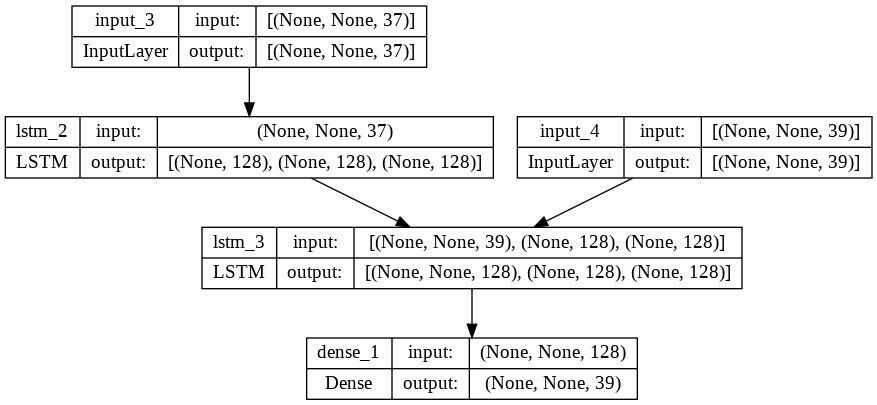

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
decode_sequence)

In [ ]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
#model = keras.models.load_model("s2s")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_3")
decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_4")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
decode_sequence   
 return decoded_sentence

ValueError: ignored

In [ ]:
test_text = 'مكضن نامض عبدالعزضز غفار'

encoder_test_data = np.zeros(
    (1, max_encoder_seq_length, num_encoder_tokens), dtype="float32")

for t, char in enumerate(test_text):
    encoder_test_data[0, t, input_token_index[char]] = 1.0

decoded_sentence = decode_sequence(encoder_test_data)
print(decoded_sentence)

1/1 [==============================] - 0s 18ms/step
ءءءءءءءءءءلءء

